# SITCOM-797

Here is what was requested:

To analyze the positioning system after a slew, create plots for the mirror

- decentering (X and Y)
- mirror tilt (RX, RY, RY)
- piston
- Create a histogram for each parameter for a configurable time period.

Include the limits in all plots:

* the mirror decenters at less than +/- 6 micrometer
* mirror tilt less than +/- 24 e-6 degree
* piston less than +/- 1 micrometer


### Prepare Notebook

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy import time
from astropy import units as u
import matplotlib.dates as mdates

from scipy.stats import linregress

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

In [4]:
# Select data from a given date
#dayObs = 20230627
#dayObs = 20230711
dayObs = 20230710
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]
tracks = [e for e in events if e.type==TMAState.TRACKING]
print(f'Found {len(slews)} slews and {len(tracks)} tracks')

Found 86 slews and 0 tracks


In [5]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

In [6]:
pos_columns = [a + "Position" for a in "xyz"]
rot_columns = [a + "Rotation" for a in "xyz"]
all_columns = pos_columns + rot_columns

## Analysis

 * Loop over all the slews
 * Compute mean, sigma and maximum difference w.r.t. the first values
 * Store results in a dataframe in order to plot them later

In [7]:
# define small amount of time to check mirror position before and after the slews
delta_t = 1
dt_begin = time.TimeDelta(-delta_t, format='sec')
dt_end = time.TimeDelta(delta_t, format='sec')

results = pd.DataFrame(columns=["i_slew", "duration", "x_mean", "y_mean", "z_mean", "x_sigma", "y_sigma", "z_sigma", 
                                "R_x_mean", "R_y_mean", "R_z_mean", "Rx_sigma", "Ry_sigma", "Rz_sigma",
                                "dx_max", "dy_max", "dz_max", "R_dx_max", "R_dy_max", "R_dz_max",
                                "x_before", "y_before", "z_before", "R_x_before", "R_y_before", "R_z_before",
                                "x_after", "y_after", "z_after", "R_x_after", "R_y_after", "R_z_after",
                                "start_ele", "end_ele", "start_azi", "end_azi", "speed_ele", "slew_end"])


for i_slew, slew in enumerate(slews):
    #print(i_slew)
    # Get ims data
    df_ims = getEfdData(client, 'lsst.sal.MTM1M3.imsData', event=slew)
    if len(df_ims) == 0:
        print(f"No data for slew number: {i_slew}")
        continue 
        
    df_ims = df_ims[all_columns]

    # Convert meter to milimeter to make is easier to analyse
    df_ims[pos_columns] = df_ims[pos_columns] * 1e3
    
    # get ims data before and after the slew
    df_ims_before = getEfdData(client, 'lsst.sal.MTM1M3.imsData', begin=slew.begin, timespan=dt_begin)
    if len(df_ims_before) == 0:
        print(f"No data before slew number: {i_slew}")
        continue 
    df_ims_before = df_ims_before[all_columns]
    df_ims_before[pos_columns] = df_ims_before[pos_columns]*u.m.to(u.mm)
    
    df_ims_after = getEfdData(client, 'lsst.sal.MTM1M3.imsData', begin=slew.end, timespan=dt_end)
    if len(df_ims_before) == 0:
        print(f"No data after slew number: {i_slew}")
        continue 
    df_ims_after = df_ims_after[all_columns]
    df_ims_after[pos_columns] = df_ims_after[pos_columns]*u.m.to(u.mm)
    
    mean = {}
    sigma = {}
    max_diff = {}
    mean_before={}
    mean_after = {}
    for col in all_columns:
        mean[col] = np.mean(df_ims[col])
        sigma[col] = np.std(df_ims[col])
        t0 = df_ims.index[0]
        max_diff[col] = np.max(np.abs(df_ims[t0:t0][col][0]-df_ims[col]))
        
        mean_before[col] = np.mean(df_ims_before[col])
        mean_after[col] = np.mean(df_ims_after[col])
        
    # get elevation data
    df_ele = getEfdData(client, 'lsst.sal.MTMount.elevation', event= slew)
    pos_ele = df_ele["actualPosition"]
    start_ele = pos_ele[pos_ele.index[0]]
    end_ele = pos_ele[pos_ele.index[len(pos_ele)-1]]
    # get speed
    speed_ele = np.mean(df_ele["demandVelocity"])
    
    # get azimuth data
    df_azi = getEfdData(client, 'lsst.sal.MTMount.azimuth', event= slew)
    pos_azi = df_azi["actualPosition"]
    start_azi = pos_azi[pos_azi.index[0]]
    end_azi = pos_azi[pos_azi.index[len(pos_azi)-1]]
        
    # Store computed values in dataframe
    vect = [[i_slew], [slew.duration], [mean[i] for i in pos_columns], [sigma[i] for i in pos_columns], [mean[i] for i in rot_columns], [sigma[i] for i in rot_columns],
            [max_diff[i] for i in pos_columns], [max_diff[i] for i in rot_columns],
            [mean_before[i] for i in pos_columns], [mean_before[i] for i in rot_columns], [mean_after[i] for i in pos_columns], [mean_after[i] for i in rot_columns],
            [start_ele], [end_ele], [start_azi], [end_azi], [speed_ele], [slew.end]]
    flat_vect = [item for sublist in vect for item in sublist]
    results = pd.concat([results, pd.DataFrame([flat_vect], columns=results.columns)], ignore_index=True)
        

In [7]:
results

,i_slew,duration,x_mean,y_mean,z_mean,x_sigma,y_sigma,z_sigma,R_x_mean,R_y_mean,...,z_after,R_x_after,R_y_after,R_z_after,start_ele,end_ele,start_azi,end_azi,speed_ele,slew_end
0,0,10.529821,-1.467891,5.573259,-1.090555,0.000122,0.000070,0.000050,-0.002689,-0.014370,...,-1.090561,-0.002690,-0.014370,0.008361,89.857499,89.857499,152.960205,151.974922,0.000000e+00,1689098593.3483126
1,1,18.661617,-1.467867,5.571195,-1.090376,0.000125,0.000534,0.000140,-0.002692,-0.014373,...,-1.090230,-0.002678,-0.014373,0.008348,89.857500,88.054417,151.942485,151.942484,-9.738160e-02,1689098616.7710545
2,2,9.975383,-1.467728,5.571993,-1.089816,0.000047,0.000105,0.000038,-0.002680,-0.014369,...,-1.089875,-0.002682,-0.014369,0.008357,88.020001,88.020000,151.924107,150.992820,0.000000e+00,1689098881.6797037
3,3,18.696425,-1.467638,5.570002,-1.089654,0.000123,0.000548,0.000082,-0.002682,-0.014374,...,-1.089556,-0.002669,-0.014372,0.008344,88.020000,86.215425,150.952580,150.952579,-9.757140e-02,1689098905.1366441
4,4,171.711508,-1.467674,5.553286,-1.095379,0.000319,0.007948,0.006304,-0.002680,-0.014374,...,-1.110488,-0.002746,-0.014346,0.008277,86.218937,43.550930,150.952579,150.952580,-2.489274e-01,1689099153.0145297
5,5,1.575718,-1.466950,5.540833,-1.111192,0.000000,0.000000,0.000000,-0.002748,-0.014337,...,-1.111192,-0.002748,-0.014337,0.008284,43.277486,43.277486,150.952771,150.952771,0.000000e+00,1689099429.7679937
6,6,593.724419,-1.466633,5.539362,-1.109878,0.000292,0.000790,0.000598,-0.002748,-0.014332,...,-1.109055,-0.002744,-0.014329,0.008287,43.277486,43.349999,150.952771,150.940308,0.000000e+00,1689100029.9288
7,7,1.589343,-1.466153,5.537577,-1.108593,0.000090,0.000001,0.000053,-0.002742,-0.014327,...,-1.108593,-0.002742,-0.014327,0.008286,43.350564,43.350564,150.940489,150.940489,0.000000e+00,1689100140.8258526
8,8,91.596498,-1.465987,5.537839,-1.108578,0.000139,0.000569,0.000266,-0.002742,-0.014324,...,-1.107300,-0.002738,-0.014322,0.008290,43.350564,45.093376,150.940489,149.895253,1.863502e-02,1689100252.9320147
9,9,180.886136,-1.464792,5.554434,-1.092122,0.000422,0.008747,0.007174,-0.002633,-0.014327,...,-1.084615,-0.002666,-0.014339,0.008362,45.111450,89.948520,149.895253,149.895253,2.479692e-01,1689100884.1079


Found 1 outliers xPosition (limit: 100 microns)
Found 14 outliers xRotation (limit: 0.55 arcsec)
Found 4 outliers yPosition (limit: 100 microns)
Found 3 outliers yRotation (limit: 0.55 arcsec)
Found 4 outliers zPosition (limit: 100 microns)
Found 7 outliers zRotation (limit: 0.55 arcsec)


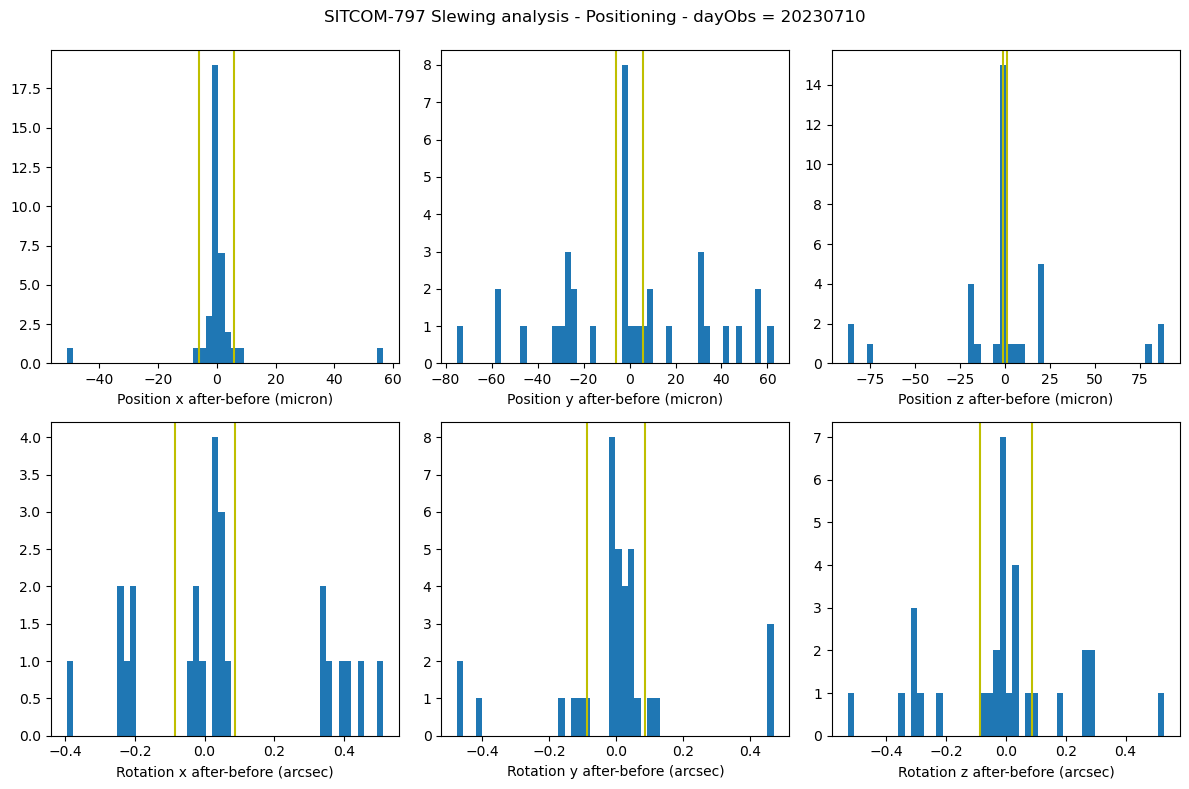

In [8]:
# Plot results (histograms)
%matplotlib inline

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

axes = "xyz"

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55 

title = f"SITCOM-797 Slewing analysis - Positioning - dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(12, 8))

# Check whether the TMA actually move in elevation
mask_move = abs(results["speed_ele"]) > 0.05

for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"])*u.mm.to(u.micron)
    mask_out = np.abs(diff) < out_limit_pos
    print(f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Position (limit: {out_limit_pos} microns)")
    mask = mask_out & mask_move
    axs[0][i].hist(diff[mask], bins=50)
    axs[0][i].set_xlabel(f"Position {axes[i]} after-before (micron)")
    
    R_diff = (results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"])*u.degree.to(u.arcsec)
    mask_out = np.abs(R_diff) < out_limit_rot
    print(f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Rotation (limit: {out_limit_rot} arcsec)")
    mask = mask_out & mask_move
    axs[1][i].hist(R_diff[mask], bins=50)
    axs[1][i].set_xlabel(f"Rotation {axes[i]} after-before (arcsec)")
    
    if axes[i] in ["x", "y"]:
        axs[0][i].axvline(6, color='y')
        axs[0][i].axvline(-6, color='y')
        axs[1][i].axvline(0.0864, color='y')
        axs[1][i].axvline(-0.0864, color='y')
    else:
        axs[0][i].axvline(1, color='y')
        axs[0][i].axvline(-1, color='y')
        axs[1][i].axvline(0.0864, color='y')
        axs[1][i].axvline(-0.0864, color='y')
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.93)

Found 1 outliers xPosition (limit: 100 microns)
Found 14 outliers xRotation (limit: 0.55 arcsec)
Found 4 outliers yPosition (limit: 100 microns)
Found 3 outliers yRotation (limit: 0.55 arcsec)
Found 4 outliers zPosition (limit: 100 microns)
Found 7 outliers zRotation (limit: 0.55 arcsec)


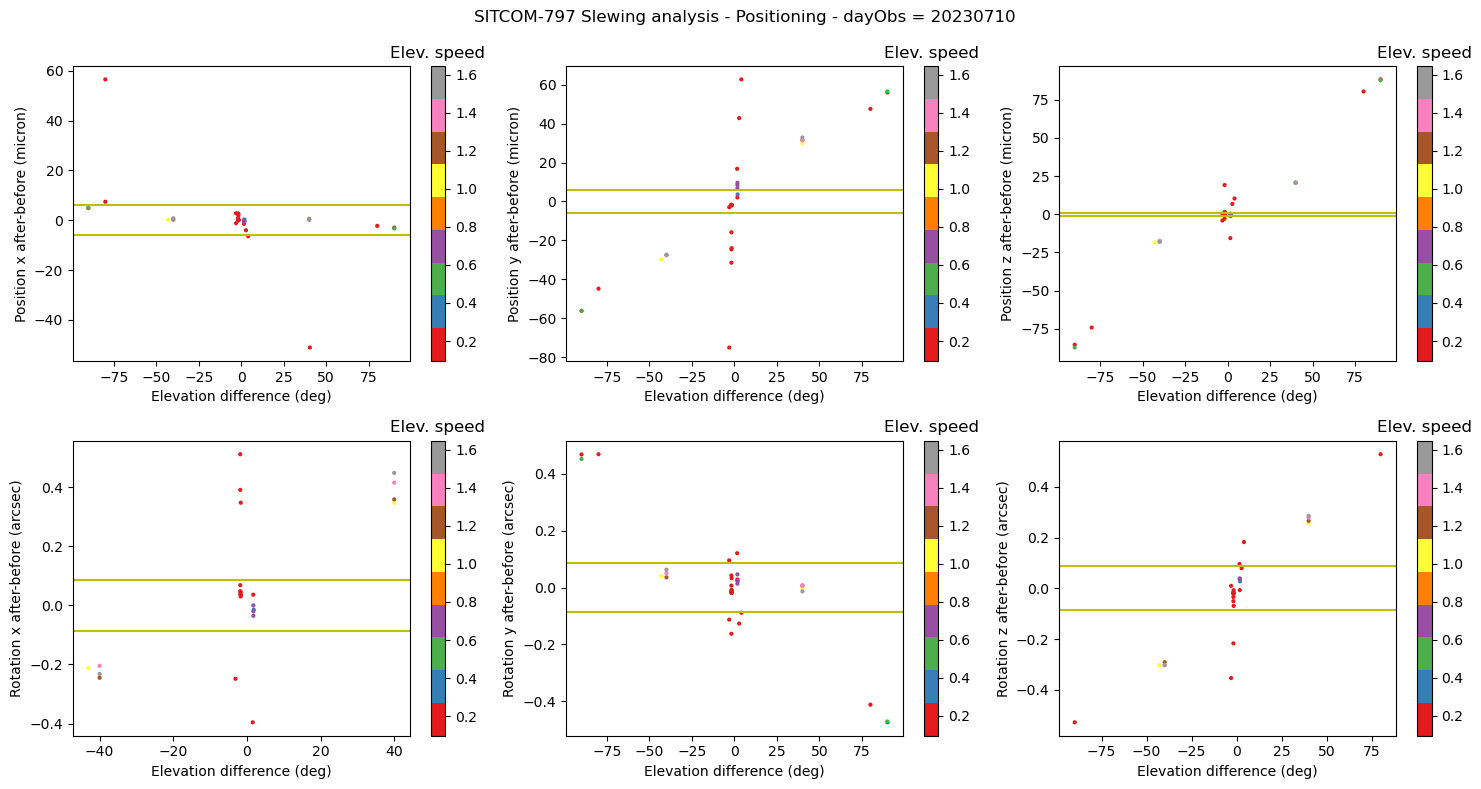

In [9]:
# Plot results (scatter plots)
locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('Set1')

axes = [ "x", "y", "z"]

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55

title = f"SITCOM-797 Slewing analysis - Positioning - dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 8))

# Check whether the TMA actually move in elevation
#mask_move = abs(results["end_ele"] - results["start_ele"]) > 1
mask_move = abs(results["speed_ele"]) > 0.05

diff_ele = results["end_ele"] - results["start_ele"]

for i in range(3):
    diff = (results[f"{axes[i]}_after"] - results[f"{axes[i]}_before"])*u.mm.to(u.micron)
    mask_out = np.abs(diff) < out_limit_pos
    print(f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Position (limit: {out_limit_pos} microns)")
    mask = mask_out & mask_move
    im = axs[0][i].scatter(diff_ele[mask], diff[mask], c=abs(results["speed_ele"][mask]), s=4, cmap=cm)
    axs[0][i].set_xlabel("Elevation difference (deg)")
    axs[0][i].set_ylabel(f"Position {axes[i]} after-before (micron)")
    clb = fig.colorbar(im, ax=axs[0][i])
    clb.ax.set_title('Elev. speed')

    R_diff = (results[f"R_{axes[i]}_after"] - results[f"R_{axes[i]}_before"])*u.degree.to(u.arcsec)
    mask_out = np.abs(R_diff) < out_limit_rot
    print(f"Found {len(results)-np.sum(mask_out)} outliers {axes[i]}Rotation (limit: {out_limit_rot} arcsec)")
    mask = mask_out & mask_move
    im = axs[1][i].scatter(diff_ele[mask], R_diff[mask], c=abs(results["speed_ele"][mask]), s=4, cmap=cm)
    axs[1][i].set_xlabel("Elevation difference (deg)")
    axs[1][i].set_ylabel(f"Rotation {axes[i]} after-before (arcsec)")
    clb = fig.colorbar(im, ax=axs[1][i])
    clb.ax.set_title('Elev. speed')
    
    if axes[i] in ["x", "y"]:
        axs[0][i].axhline(6, color='y')
        axs[0][i].axhline(-6, color='y')
        axs[1][i].axhline(0.0864, color='y')
        axs[1][i].axhline(-0.0864, color='y')
    else:
        axs[0][i].axhline(1, color='y')
        axs[0][i].axhline(-1, color='y')
        axs[1][i].axhline(0.0864, color='y')
        axs[1][i].axhline(-0.0864, color='y')
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

Found 4 outliers for pair xy (limit: 100 microns)
Found 14 outliers for pair xy (limit: 0.55 arcsec)
Found 4 outliers for pair yz (limit: 100 microns)
Found 7 outliers for pair yz (limit: 0.55 arcsec)
Found 4 outliers for pair xz (limit: 100 microns)
Found 14 outliers for pair xz (limit: 0.55 arcsec)


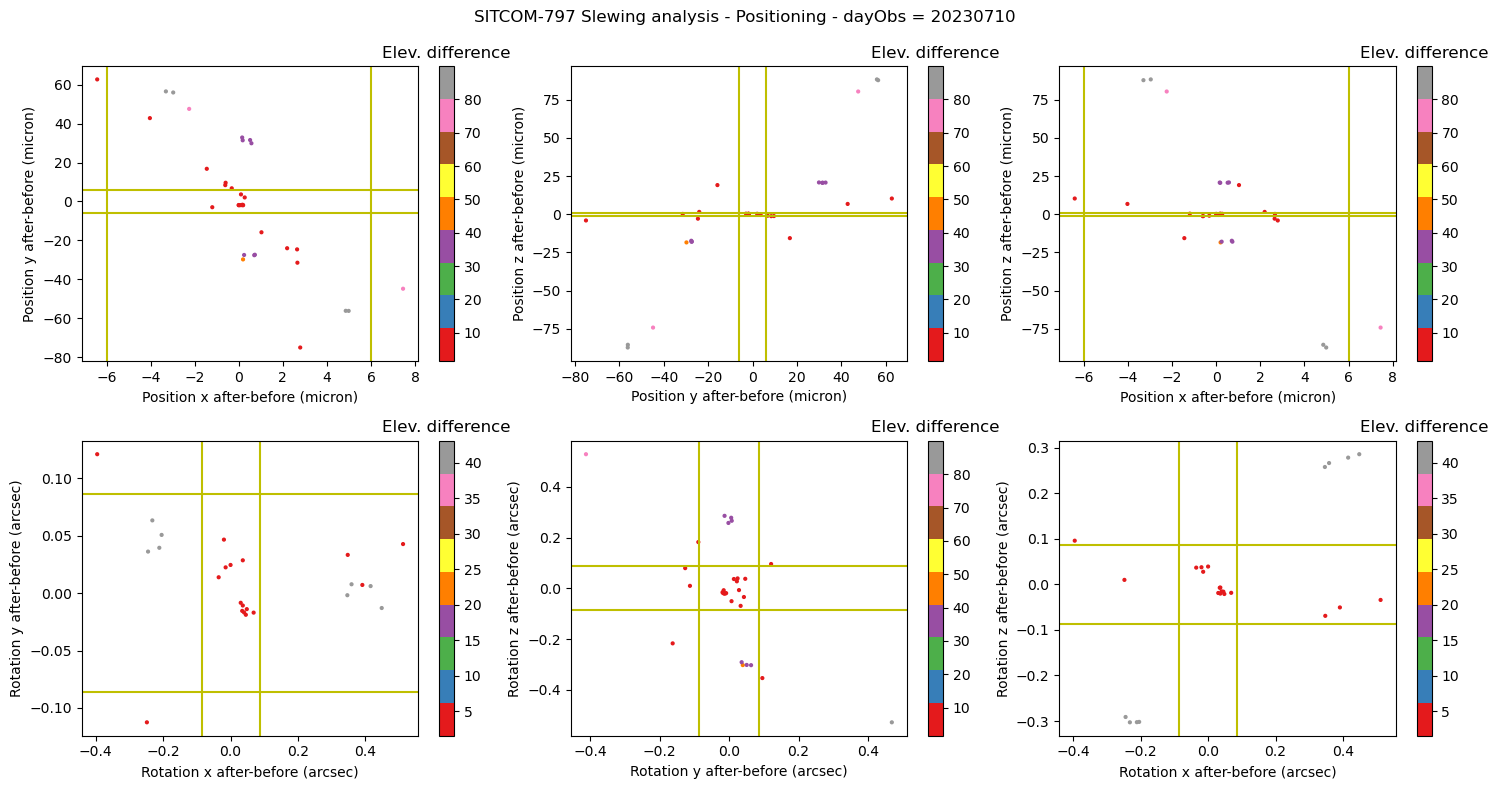

In [10]:
# Plot results (scatter plots)
locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

#cm = plt.cm.get_cmap('RdYlBu')
cm = plt.cm.get_cmap('Set1')

pairs = [ "xy", "yz", "xz"]

# limit on position (micron) or rotation (arcsec) for ouliers
out_limit_pos = 100
out_limit_rot = 0.55

title = f"SITCOM-797 Slewing analysis - Positioning - dayObs = {dayObs}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(15, 8))

# Check whether the TMA actually move in elevation
mask_move = abs(results["speed_ele"]) > 0.05

# Elevation change
diff_ele = results["end_ele"] - results["start_ele"]

for i in range(3):
    pair = pairs[i]
    
    # Positions
    diff_1 = (results[f"{pair[0]}_after"] - results[f"{pair[0]}_before"])*u.mm.to(u.micron)
    diff_2 = (results[f"{pair[1]}_after"] - results[f"{pair[1]}_before"])*u.mm.to(u.micron)
    mask_out = (np.abs(diff_1) < out_limit_pos) & (np.abs(diff_2) < out_limit_pos)
    print(f"Found {len(results)-np.sum(mask_out)} outliers for pair {pair} (limit: {out_limit_pos} microns)")
    mask = mask_out & mask_move
    im = axs[0][i].scatter(diff_1[mask], diff_2[mask], c=abs(diff_ele[mask]), s=4, cmap=cm)
    axs[0][i].set_xlabel(f"Position {pair[0]} after-before (micron)")
    axs[0][i].set_ylabel(f"Position {pair[1]} after-before (micron)")
    clb = fig.colorbar(im, ax=axs[0][i])
    clb.ax.set_title('Elev. difference')
    
    if pair[0] == 'x' or pair[0] == 'y':
        axs[0][i].axvline(6, color='y')
        axs[0][i].axvline(-6, color='y')
    else:
        axs[0][i].axvline(1, color='y')
        axs[0][i].axvline(-1, color='y')
        
    if pair[1] == 'x' or pair[1] == 'y':
        axs[0][i].axhline(6, color='y')
        axs[0][i].axhline(-6, color='y')
    else:
        axs[0][i].axhline(1, color='y')
        axs[0][i].axhline(-1, color='y')
    
    # Rotations
    R_diff_1 = (results[f"R_{pair[0]}_after"] - results[f"R_{pair[0]}_before"])*u.degree.to(u.arcsec)
    R_diff_2 = (results[f"R_{pair[1]}_after"] - results[f"R_{pair[1]}_before"])*u.degree.to(u.arcsec)
    mask_out = (np.abs(R_diff_1) < out_limit_rot) & (np.abs(R_diff_2) < out_limit_rot)
    print(f"Found {len(results)-np.sum(mask_out)} outliers for pair {pair} (limit: {out_limit_rot} arcsec)")
    mask = mask_out & mask_move
    im = axs[1][i].scatter(R_diff_1[mask], R_diff_2[mask], c=abs(diff_ele[mask]), s=4, cmap=cm)
    axs[1][i].set_xlabel(f"Rotation {pair[0]} after-before (arcsec)")
    axs[1][i].set_ylabel(f"Rotation {pair[1]} after-before (arcsec)")
    clb = fig.colorbar(im, ax=axs[1][i])
    clb.ax.set_title('Elev. difference')
    
    axs[1][i].axhline(0.0864, color='y')
    axs[1][i].axhline(-0.0864, color='y')
    axs[1][i].axvline(0.0864, color='y')
    axs[1][i].axvline(-0.0864, color='y')
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

## Now we select one specific large amplitude slew in order to analyse the variation of the positions / rotations as a function of time 

In [14]:
# Find the slew where the elevation difference is maximum
ele_index = np.argmax(diff_ele)
#ele_index=19
#ele_index=14
print("Elevation difference of slew %i: %.1f degrees"%(ele_index, diff_ele[ele_index]))
print("Start elevattion is %.1f degrees - End elevation is %.1f degrees"%(results["start_ele"][ele_index], results["end_ele"][ele_index]))

Elevation difference of slew 31: 90.0 degrees
Start elevattion is -0.0 degrees - End elevation is 89.9 degrees


In [15]:
# Get ims data covering the selected slew plus some extra time before and after the slew
delta_t = 40
dt_end = time.TimeDelta(delta_t, format='sec')
dt_begin = time.TimeDelta(delta_t, format='sec')
df_ims = getEfdData(client, 'lsst.sal.MTM1M3.imsData', begin=slews[ele_index].begin-dt_begin, end=slews[ele_index].end+dt_end)

# We also retreive the data correesponding to the exact slew duration in order to be able to find the start and the end of the slew
df_ims_slew = getEfdData(client, 'lsst.sal.MTM1M3.imsData', begin=slews[ele_index].begin, end=slews[ele_index].end)

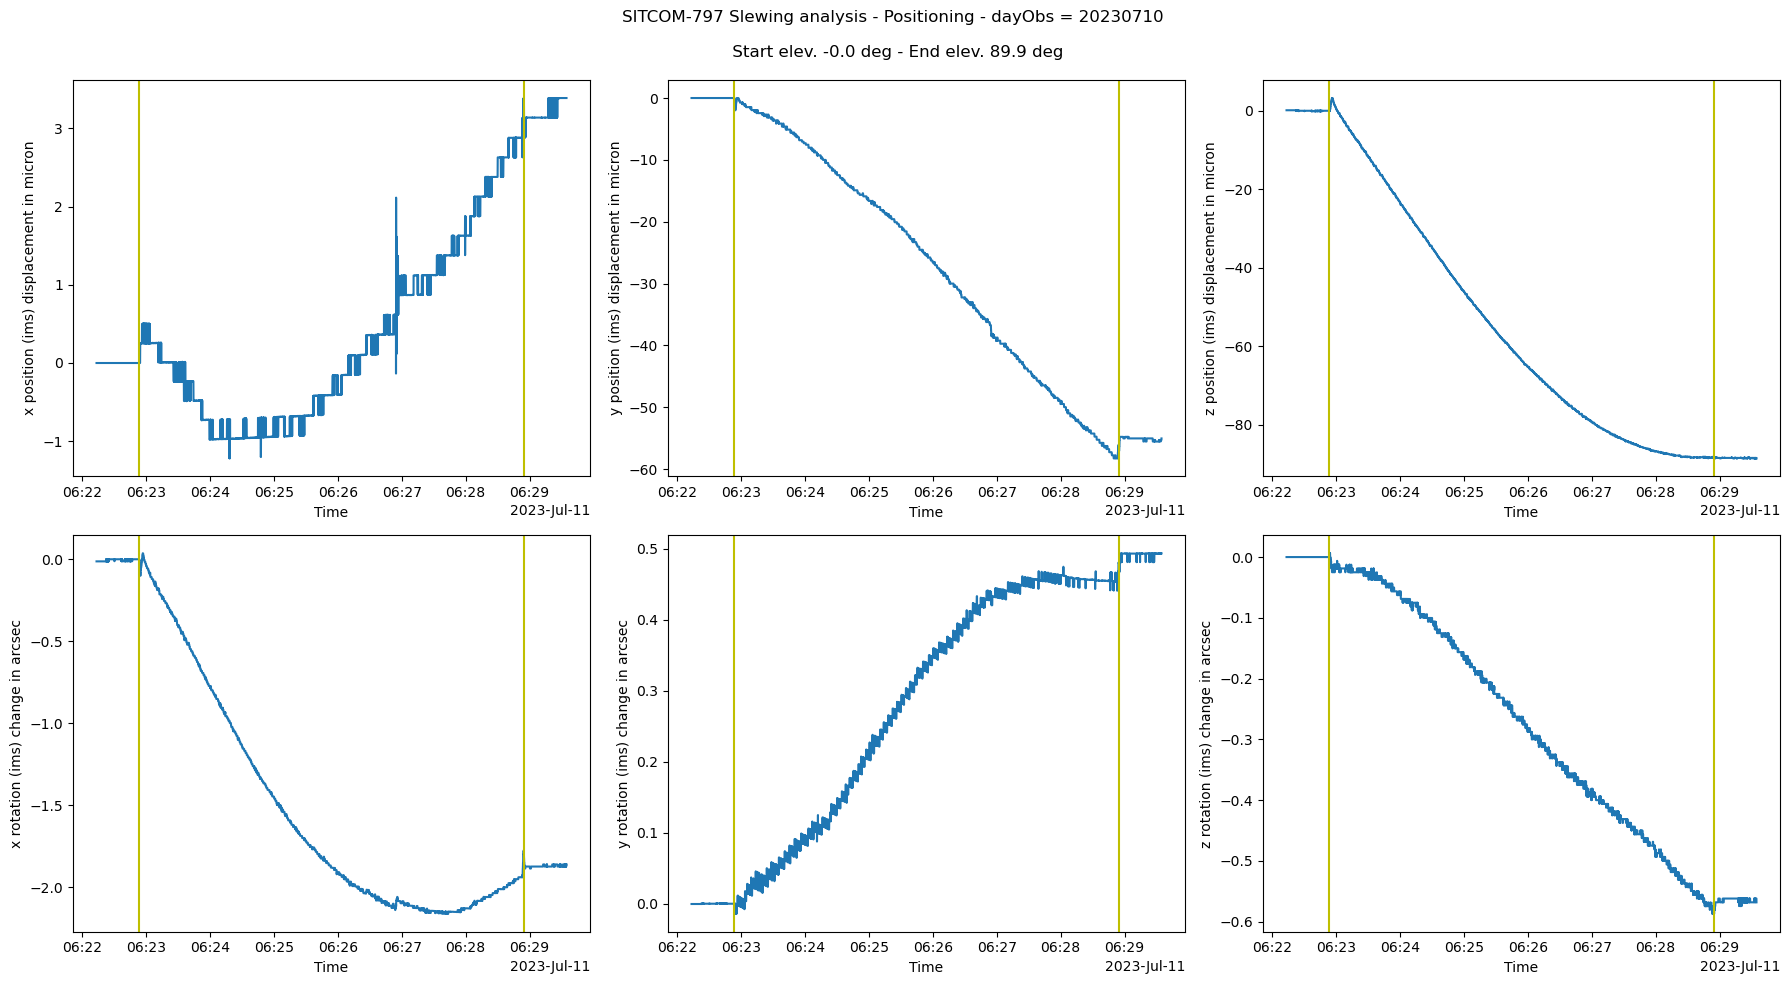

In [16]:
# Plot positions and rotation versus time

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

title = "SITCOM-797 Slewing analysis - Positioning - dayObs = %s \n\n Start elev. %.1f deg - End elev. %.1f deg"%(dayObs, results['start_ele'][ele_index], results['end_ele'][ele_index])
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(18, 10))

axes = "xyz"
for i in range(3):
    axis = axes[i]
    
    # Positions
    _ = axs[0][i].plot(df_ims.index, (results[f"{axis}_before"][ele_index]-df_ims[f"{axis}Position"]*u.m.to(u.mm))*u.mm.to(u.micron))
    axs[0][i].axvline(df_ims_slew.index[0], c="y")
    axs[0][i].axvline(df_ims_slew.index[-1], c="y")
    axs[0][i].set_xlabel("Time")
    axs[0][i].set_ylabel(f"{axis} position (ims) displacement in micron")
    axs[0][i].xaxis.set_major_formatter(formatter)
    
    # Rotations
    _ = axs[1][i].plot(df_ims.index, (results[f"R_{axis}_before"][ele_index]-df_ims[f"{axis}Rotation"])*u.degree.to(u.arcsec))
    axs[1][i].axvline(df_ims_slew.index[0], c="y")
    axs[1][i].axvline(df_ims_slew.index[-1], c="y")
    axs[1][i].set_xlabel("Time")
    axs[1][i].set_ylabel(f"{axis} rotation (ims) change in arcsec")
    axs[1][i].xaxis.set_major_formatter(formatter)
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

In [17]:
# Get Hard Point Monitor Data
df_hpmd = getEfdData(client, 'lsst.sal.MTM1M3.hardpointMonitorData', begin=slews[ele_index].begin-dt_begin, end=slews[ele_index].end+dt_end)

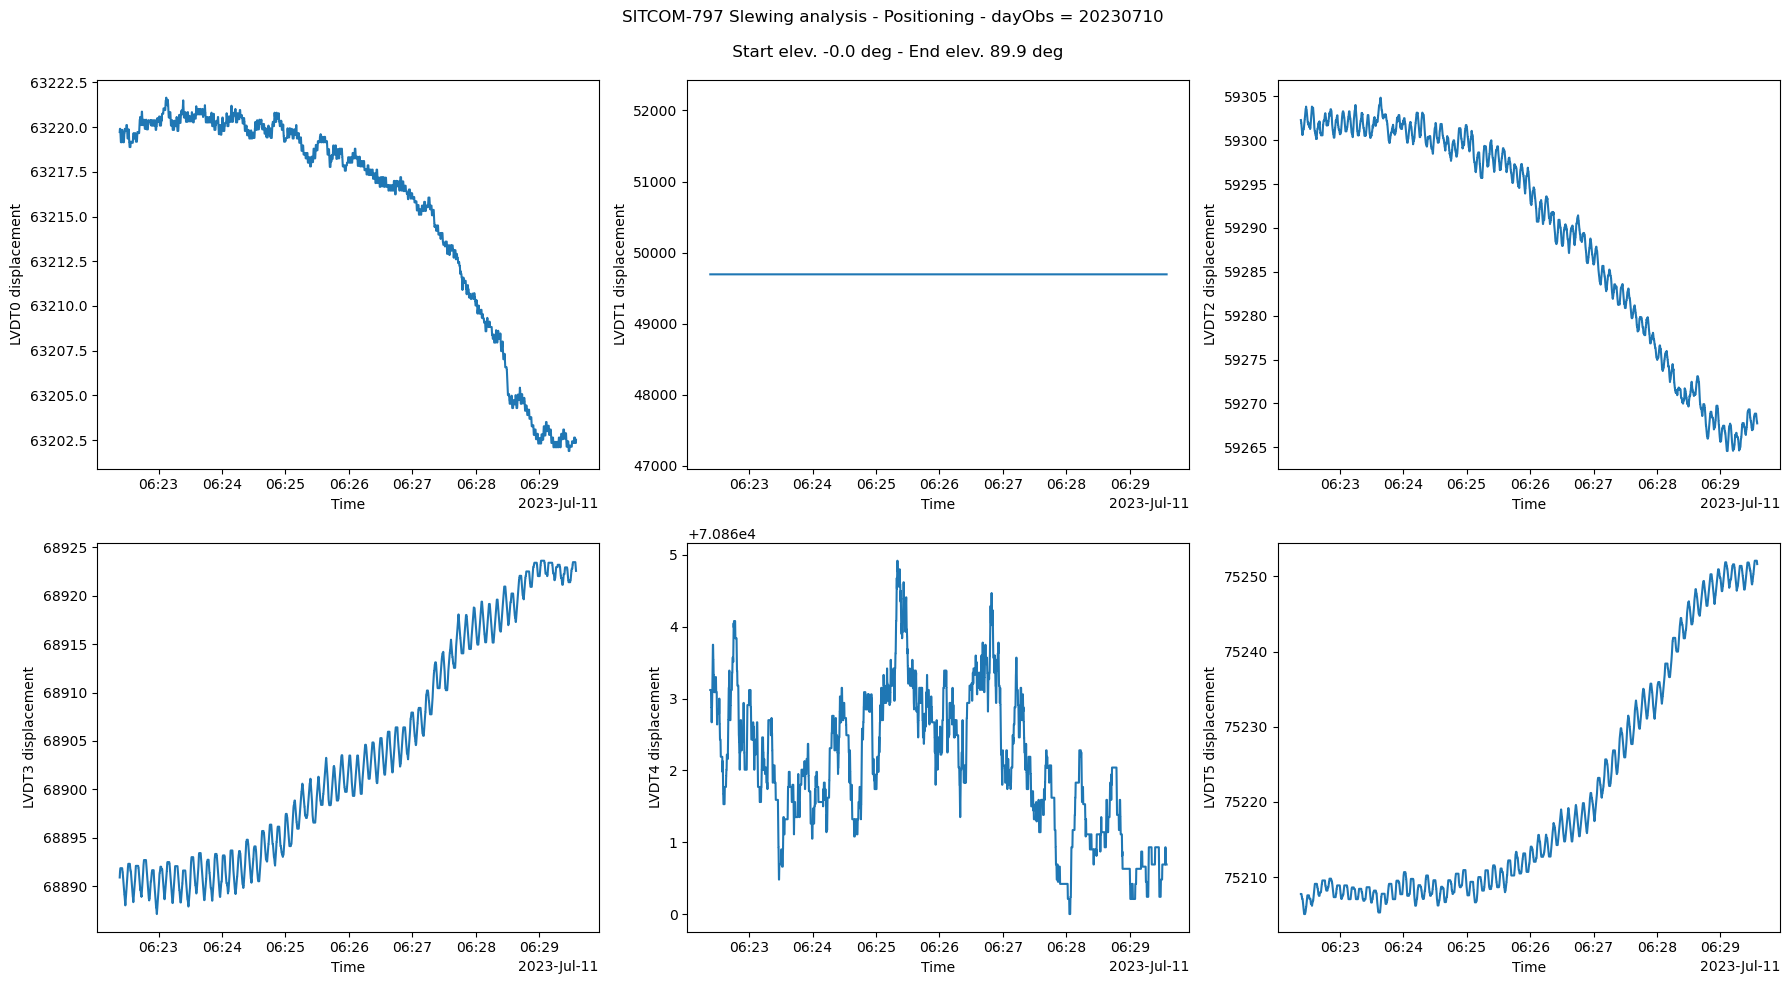

In [18]:
# Plot Hard Point LVDT displacement

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

title = "SITCOM-797 Slewing analysis - Positioning - dayObs = %s \n\n Start elev. %.1f deg - End elev. %.1f deg"%(dayObs, results['start_ele'][ele_index], results['end_ele'][ele_index])
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(18, 10))

for i in range(6):
    if i < 3:
        j = 0
        k = i
    else:
        j = 1
        k = i-3
    # From Craig, me need to smooth the data in order to get a usable signal --> rolling mean over 500 data points
    smoothed_monitor_data = df_hpmd[f"displacementLVDT{str(i)}"].rolling(500).mean() * 15000.0
#    _ = axs[j][k].plot(df_hpmd.index, df_hpmd[f"displacementLVDT{str(i)}"], "r+")
    _ = axs[j][k].plot(df_hpmd.index, smoothed_monitor_data)
    axs[j][k].set_xlabel("Time")
    axs[j][k].set_ylabel(f"LVDT{str(i)} displacement")
    axs[j][k].xaxis.set_major_formatter(formatter)
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

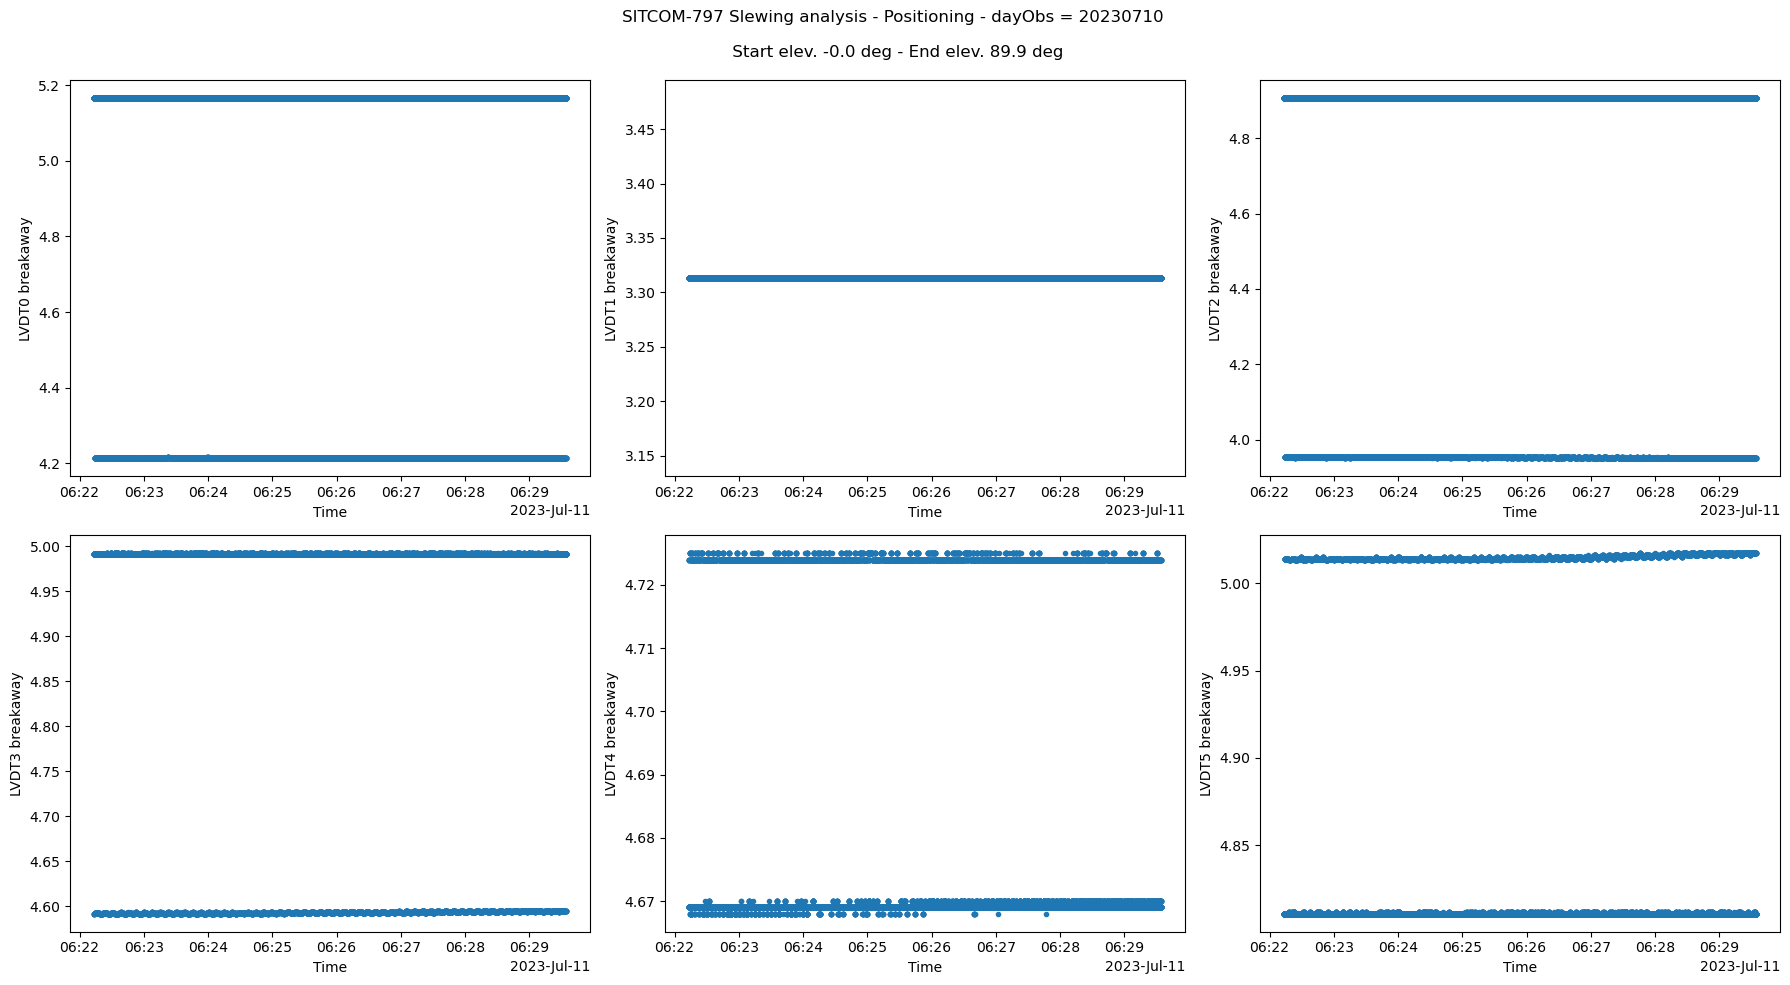

In [19]:
# Plot Hard Point breakaway LVDT

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

title = "SITCOM-797 Slewing analysis - Positioning - dayObs = %s \n\n Start elev. %.1f deg - End elev. %.1f deg"%(dayObs, results['start_ele'][ele_index], results['end_ele'][ele_index])
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(18, 10))

for i in range(6):
    if i < 3:
        j = 0
        k = i
    else:
        j = 1
        k = i-3
    # From Craig, me need to smooth the data in order to get a usable signal --> rolling mean over 500 data points
    #smoothed_monitor_data = df_hpmd[f"displacementLVDT{str(i)}"].rolling(500).mean() * 15000.0
    _ = axs[j][k].plot(df_hpmd.index, df_hpmd[f"breakawayLVDT{str(i)}"], ".")
#    _ = axs[j][k].plot(df_hpmd.index, smoothed_monitor_data)
    axs[j][k].set_xlabel("Time")
    axs[j][k].set_ylabel(f"LVDT{str(i)} breakaway")
    axs[j][k].xaxis.set_major_formatter(formatter)
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

In [21]:
# Get Hard Point Actuator Data
df_hpad = getEfdData(client, 'lsst.sal.MTM1M3.hardpointActuatorData', begin=slews[ele_index].begin-dt_begin, end=slews[ele_index].end+dt_end)

In [31]:
df_hpad.keys()

Index(['displacement0', 'displacement1', 'displacement2', 'displacement3',
       'displacement4', 'displacement5', 'encoder0', 'encoder1', 'encoder2',
       'encoder3', 'encoder4', 'encoder5', 'forceMagnitude', 'fx', 'fy', 'fz',
       'measuredForce0', 'measuredForce1', 'measuredForce2', 'measuredForce3',
       'measuredForce4', 'measuredForce5', 'mx', 'my', 'mz',
       'private_efdStamp', 'private_identity', 'private_kafkaStamp',
       'private_origin', 'private_rcvStamp', 'private_revCode',
       'private_seqNum', 'private_sndStamp', 'stepsCommanded0',
       'stepsCommanded1', 'stepsCommanded2', 'stepsCommanded3',
       'stepsCommanded4', 'stepsCommanded5', 'stepsQueued0', 'stepsQueued1',
       'stepsQueued2', 'stepsQueued3', 'stepsQueued4', 'stepsQueued5',
       'timestamp', 'xPosition', 'xRotation', 'yPosition', 'yRotation',
       'zPosition', 'zRotation'],
      dtype='object')

In [35]:
df_hpmd.keys()

Index(['breakawayLVDT0', 'breakawayLVDT1', 'breakawayLVDT2', 'breakawayLVDT3',
       'breakawayLVDT4', 'breakawayLVDT5', 'breakawayPressure0',
       'breakawayPressure1', 'breakawayPressure2', 'breakawayPressure3',
       'breakawayPressure4', 'breakawayPressure5', 'displacementLVDT0',
       'displacementLVDT1', 'displacementLVDT2', 'displacementLVDT3',
       'displacementLVDT4', 'displacementLVDT5', 'pressureSensor10',
       'pressureSensor11', 'pressureSensor12', 'pressureSensor13',
       'pressureSensor14', 'pressureSensor15', 'pressureSensor20',
       'pressureSensor21', 'pressureSensor22', 'pressureSensor23',
       'pressureSensor24', 'pressureSensor25', 'pressureSensor30',
       'pressureSensor31', 'pressureSensor32', 'pressureSensor33',
       'pressureSensor34', 'pressureSensor35', 'private_efdStamp',
       'private_identity', 'private_kafkaStamp', 'private_origin',
       'private_rcvStamp', 'private_revCode', 'private_seqNum',
       'private_sndStamp', 'timestamp']

In [19]:
df_hpad.measuredForce0

2023-07-11 19:10:26.011546+00:00   -295.953186
2023-07-11 19:10:26.031769+00:00   -295.650055
2023-07-11 19:10:26.051552+00:00   -295.751099
2023-07-11 19:10:26.071198+00:00   -294.504913
2023-07-11 19:10:26.091549+00:00   -297.030975
                                       ...    
2023-07-11 19:12:37.820325+00:00    -86.155487
2023-07-11 19:12:37.840438+00:00    -83.427345
2023-07-11 19:12:37.860209+00:00    -87.671120
2023-07-11 19:12:37.880210+00:00    -83.966232
2023-07-11 19:12:37.900327+00:00    -85.650276
Name: measuredForce0, Length: 6587, dtype: float64

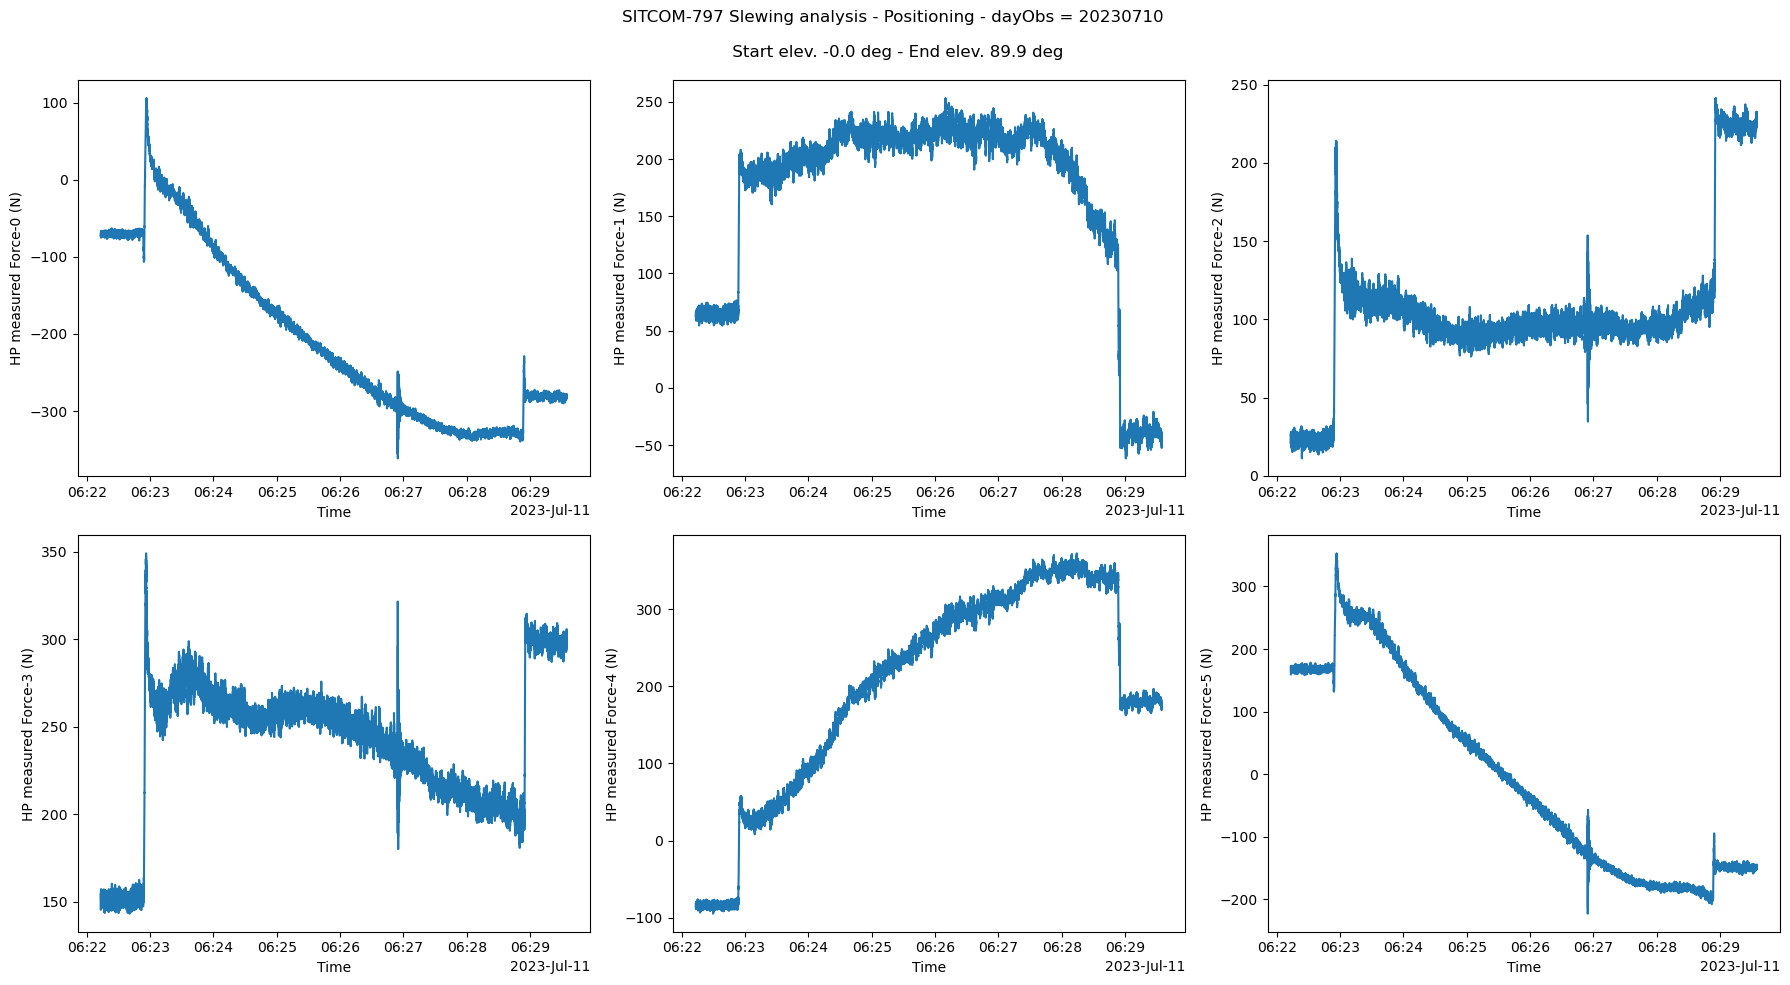

In [22]:
# Plot Hard Point measured forces

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

title = "SITCOM-797 Slewing analysis - Positioning - dayObs = %s \n\n Start elev. %.1f deg - End elev. %.1f deg"%(dayObs, results['start_ele'][ele_index], results['end_ele'][ele_index])
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(18, 10))

for i in range(6):
    if i < 3:
        j = 0
        k = i
    else:
        j = 1
        k = i-3
    _ = axs[j][k].plot(df_hpad.index, df_hpad[f"measuredForce{str(i)}"])
    axs[j][k].set_xlabel("Time")
    axs[j][k].set_ylabel(f"HP measured Force-{str(i)} (N)")
    axs[j][k].xaxis.set_major_formatter(formatter)
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

## To do : breakawayLVDT vs displacementLVDT

In [95]:
from astropy.time import Time, TimezoneInfo

# Define time frame to retrieve data in the EFD database
# This period corresponds to a HP breakaway test 
#t_start = Time("2023-07-10T23:27:00", format="isot", scale="utc")
#t_end = Time("2023-07-11T00:34:00", format="isot", scale="utc")

t_start = Time("2023-07-18T21:22:00", format="isot", scale="utc")
t_end = Time("2023-07-18T23:14:00", format="isot", scale="utc")


# Get Hard Point Monitor Data
df_hpmd = getEfdData(client, 'lsst.sal.MTM1M3.hardpointMonitorData', begin=t_start, end=t_end)
df_hpad = getEfdData(client, 'lsst.sal.MTM1M3.hardpointActuatorData', begin=t_start, end=t_end)

In [22]:
df_hpmd

,breakawayLVDT0,breakawayLVDT1,breakawayLVDT2,breakawayLVDT3,breakawayLVDT4,breakawayLVDT5,breakawayPressure0,breakawayPressure1,breakawayPressure2,breakawayPressure3,...,pressureSensor35,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,timestamp
2023-07-10 23:27:00.014154+00:00,5.163,5.003,4.907,4.991,5.203,4.811,120.358063,120.347893,120.256340,120.347893,...,0.213617,1.689032e+09,MTM1M3,1.689032e+09,8712,1.689032e+09,8a1c8871,5224961,1.689032e+09,1.689032e+09
2023-07-10 23:27:00.034357+00:00,5.162,5.003,4.907,4.991,5.203,4.812,120.358063,120.347893,120.256340,120.347893,...,0.244134,1.689032e+09,MTM1M3,1.689032e+09,8712,1.689032e+09,8a1c8871,5224962,1.689032e+09,1.689032e+09
2023-07-10 23:27:00.054339+00:00,5.162,5.003,4.907,4.991,5.203,4.812,120.358063,120.347893,120.256340,120.327545,...,0.244134,1.689032e+09,MTM1M3,1.689032e+09,8712,1.689032e+09,8a1c8871,5224963,1.689032e+09,1.689032e+09
2023-07-10 23:27:00.074399+00:00,5.162,5.003,4.907,4.991,5.203,4.812,120.358063,120.347893,120.286858,120.327545,...,0.244134,1.689032e+09,MTM1M3,1.689032e+09,8712,1.689032e+09,8a1c8871,5224964,1.689032e+09,1.689032e+09
2023-07-10 23:27:00.094237+00:00,5.162,5.003,4.907,4.991,5.203,4.812,120.358063,120.347893,120.286858,120.327545,...,0.244134,1.689032e+09,MTM1M3,1.689032e+09,8712,1.689032e+09,8a1c8871,5224965,1.689032e+09,1.689032e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-11 00:33:59.907401+00:00,5.384,5.338,5.361,5.455,5.610,5.226,120.358063,120.378410,120.286858,120.347893,...,0.244134,1.689036e+09,MTM1M3,1.689036e+09,8712,1.689036e+09,8a1c8871,5425950,1.689036e+09,1.689036e+09
2023-07-11 00:33:59.927428+00:00,5.384,5.338,5.361,5.455,5.610,5.226,120.358063,120.378410,120.286858,120.347893,...,0.244134,1.689036e+09,MTM1M3,1.689036e+09,8712,1.689036e+09,8a1c8871,5425951,1.689036e+09,1.689036e+09
2023-07-11 00:33:59.947493+00:00,5.384,5.338,5.361,5.455,5.610,5.226,120.358063,120.378410,120.286858,120.347893,...,0.244134,1.689036e+09,MTM1M3,1.689036e+09,8712,1.689036e+09,8a1c8871,5425952,1.689036e+09,1.689036e+09
2023-07-11 00:33:59.967481+00:00,5.384,5.338,5.361,5.455,5.610,5.226,120.358063,120.347893,120.256340,120.347893,...,0.244134,1.689036e+09,MTM1M3,1.689036e+09,8712,1.689036e+09,8a1c8871,5425953,1.689036e+09,1.689036e+09


In [96]:
df_hpst = getEfdData(client, "lsst.sal.MTM1M3.logevent_hardpointActuatorState", begin=t_start, end=t_end)
df_state = getEfdData(client, "lsst.sal.MTM1M3.logevent_detailedState", begin=t_start, end=t_end)

In [97]:
print(len(df_hpmd), len(df_hpad))

320835 320835


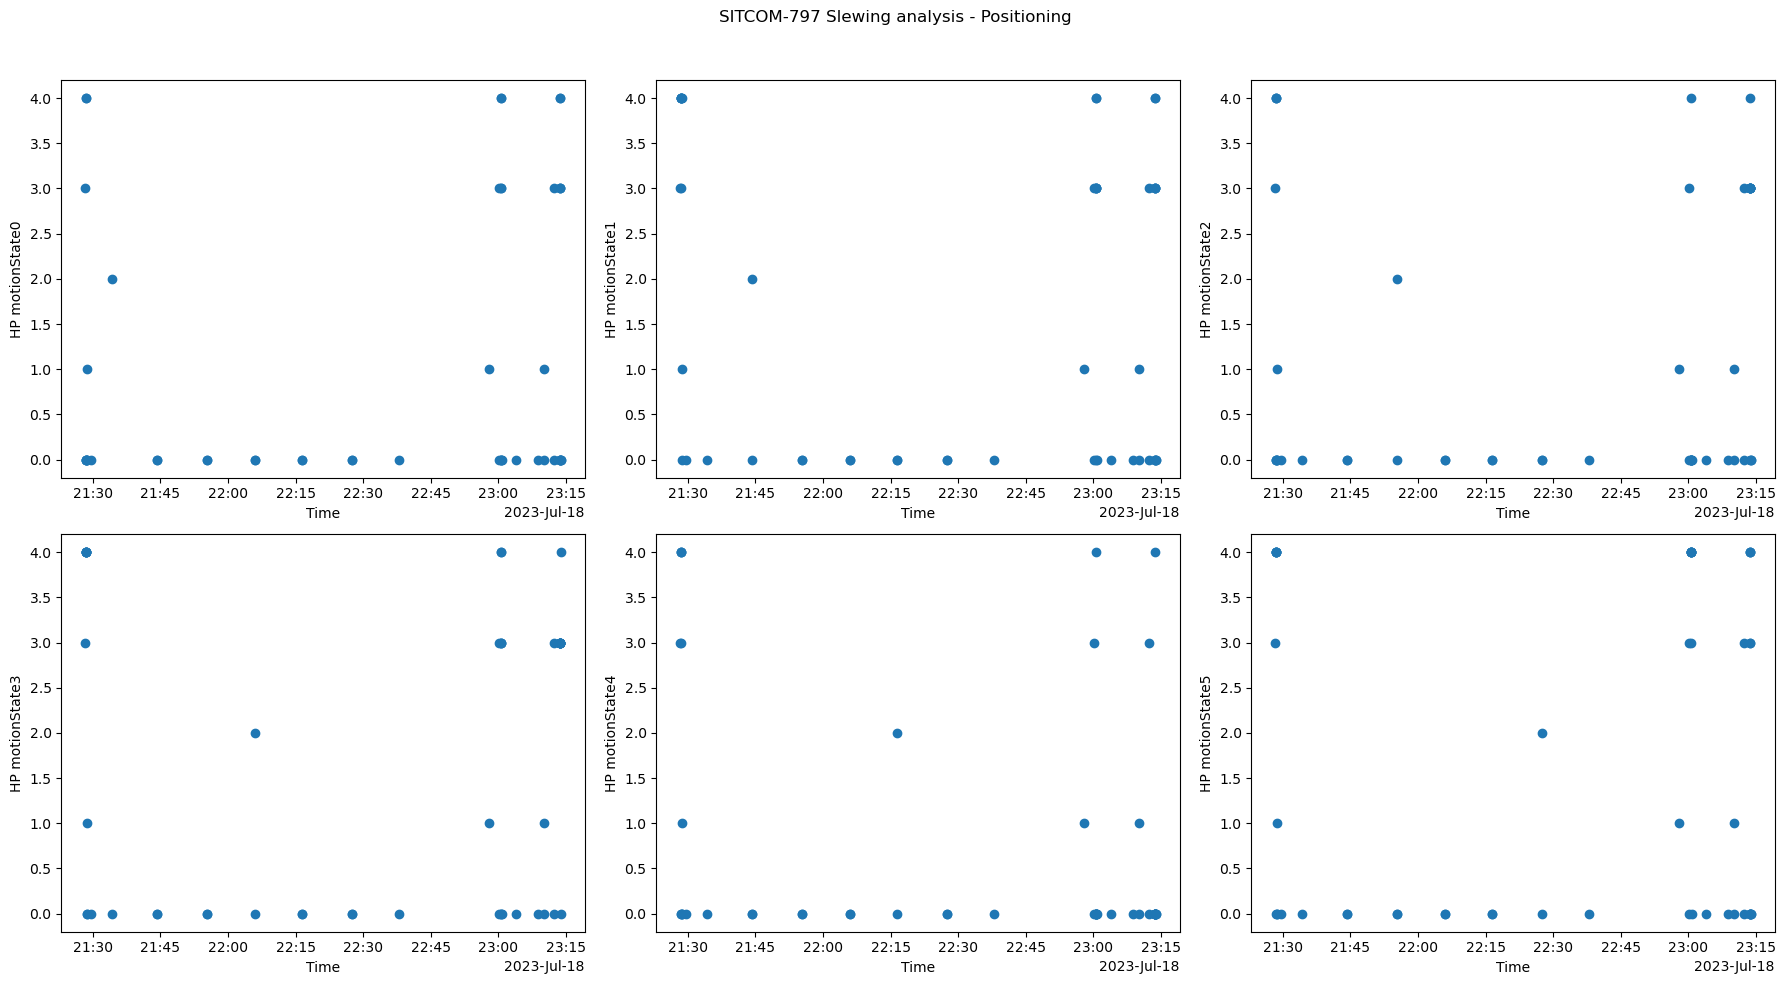

In [98]:
# Plot Hard Point motion states

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

title = "SITCOM-797 Slewing analysis - Positioning"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(18, 10))

for i in range(6):
    if i < 3:
        j = 0
        k = i
    else:
        j = 1
        k = i-3
    _ = axs[j][k].plot(df_hpst.index, df_hpst[f"motionState{str(i)}"], "o")
    axs[j][k].set_xlabel("Time")
    axs[j][k].set_ylabel(f"HP motionState{str(i)}")
    axs[j][k].xaxis.set_major_formatter(formatter)
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

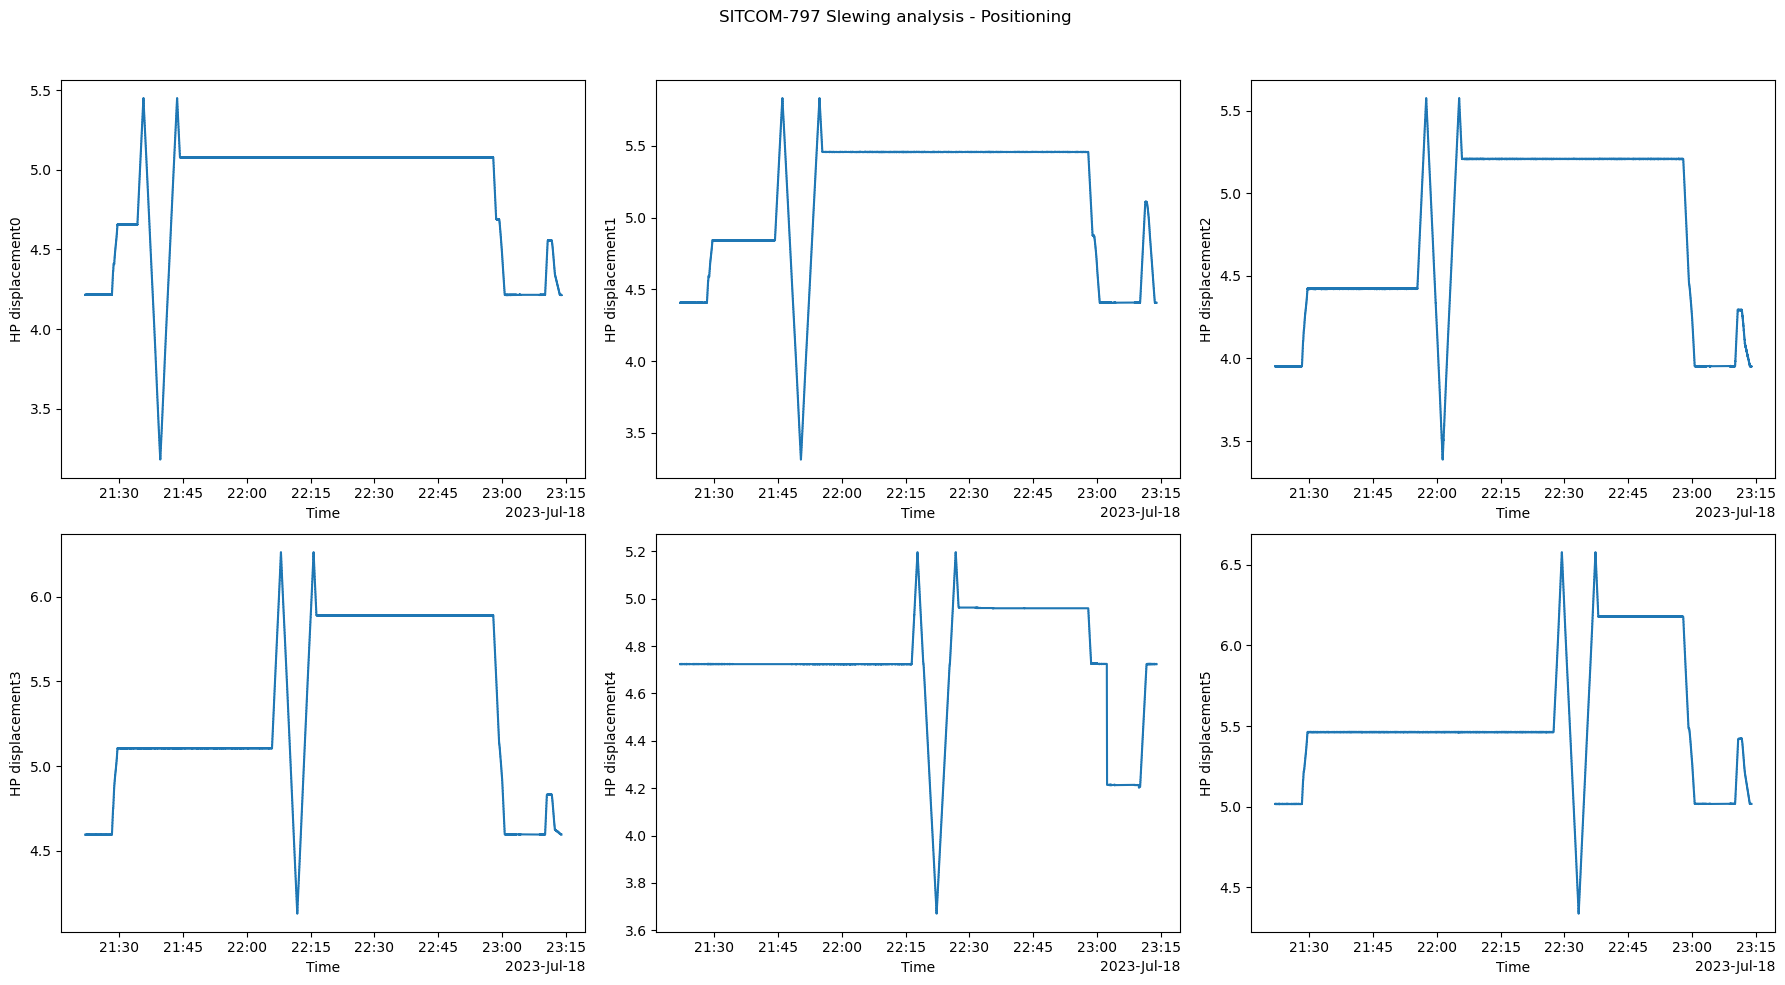

In [99]:
# Plot Hard Point displacements

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

title = "SITCOM-797 Slewing analysis - Positioning"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(18, 10))

for i in range(6):
    if i < 3:
        j = 0
        k = i
    else:
        j = 1
        k = i-3
    _ = axs[j][k].plot(df_hpmd.index, df_hpmd[f"displacementLVDT{str(i)}"])
    axs[j][k].set_xlabel("Time")
    axs[j][k].set_ylabel(f"HP displacement{str(i)}")
    axs[j][k].xaxis.set_major_formatter(formatter)
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

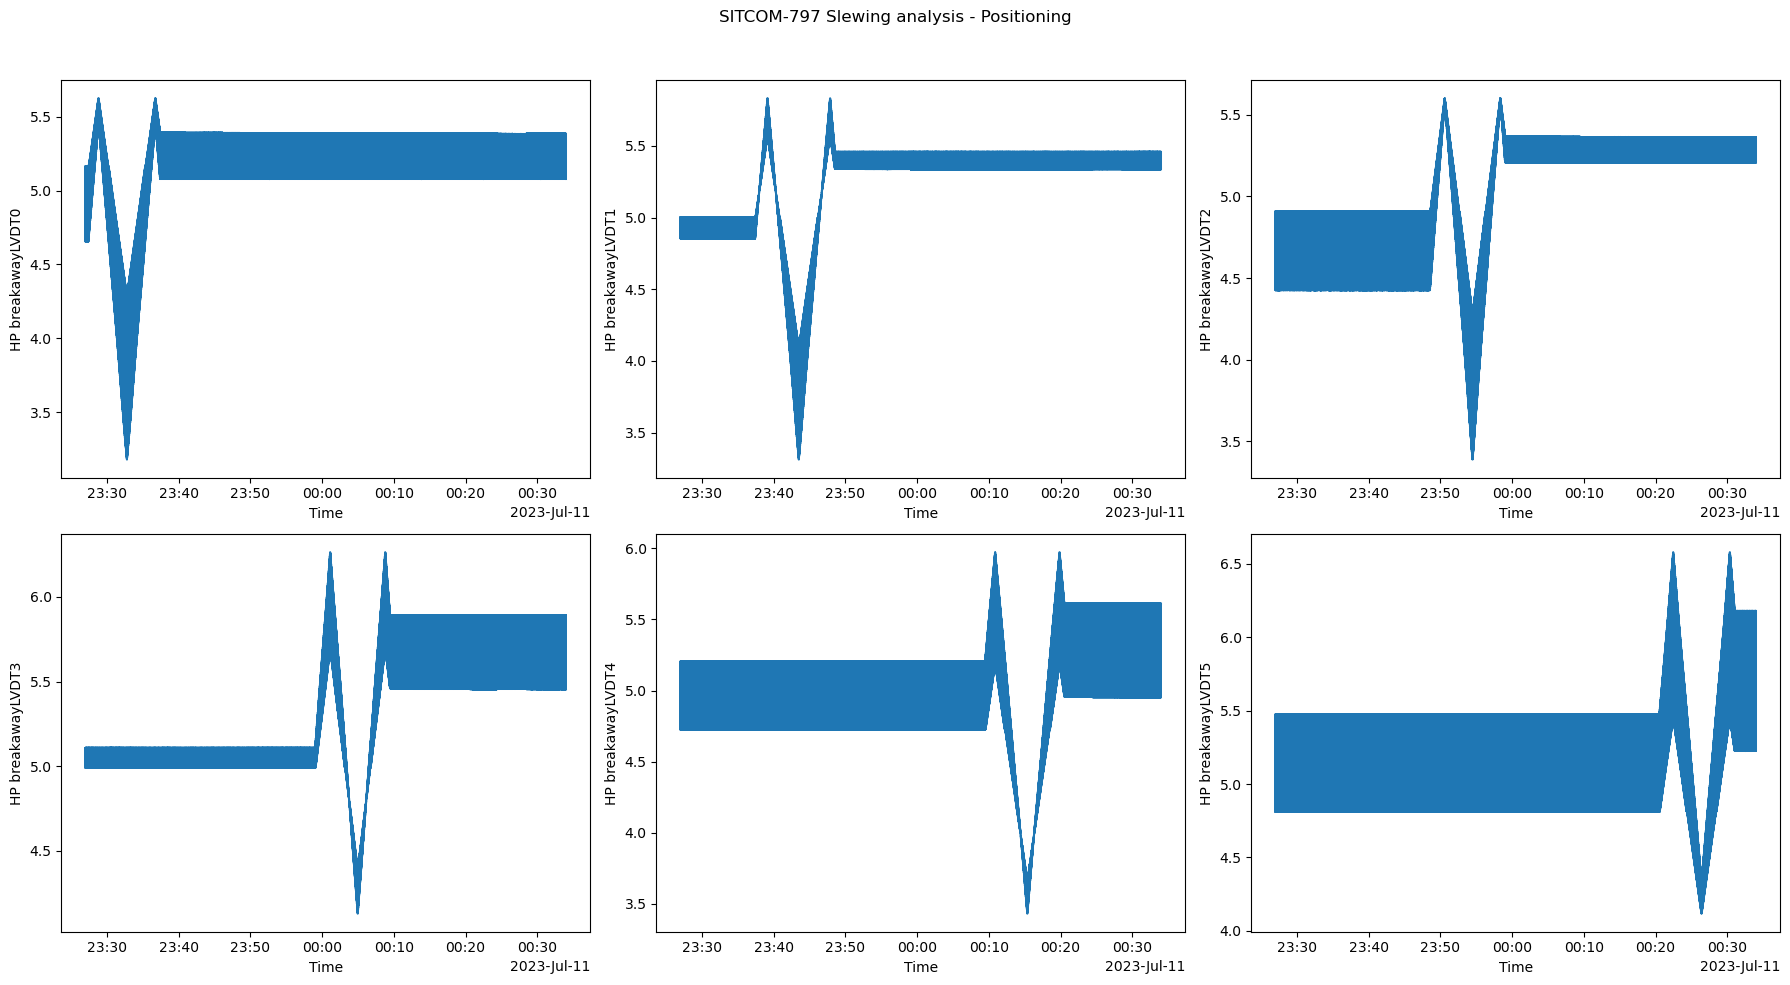

In [29]:
# Plot Hard Point breakawayLVDT

locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

title = "SITCOM-797 Slewing analysis - Positioning"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(18, 10))

for i in range(6):
    if i < 3:
        j = 0
        k = i
    else:
        j = 1
        k = i-3
    _ = axs[j][k].plot(df_hpmd.index, df_hpmd[f"breakawayLVDT{str(i)}"])
    axs[j][k].set_xlabel("Time")
    axs[j][k].set_ylabel(f"HP breakawayLVDT{str(i)}")
    axs[j][k].xaxis.set_major_formatter(formatter)
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

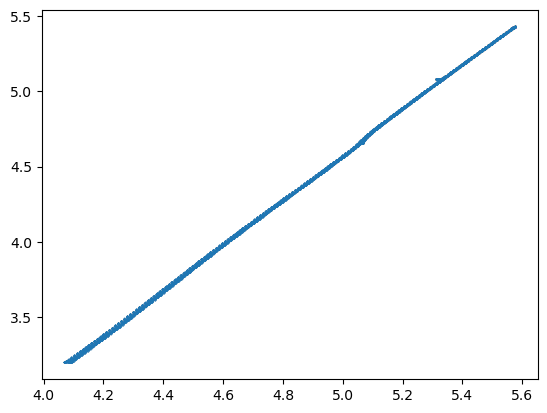

In [42]:
plt.scatter(smoothed_brk, smoothed_dis, s=0.01)

In [26]:
df_hpmd.keys()

Index(['breakawayLVDT0', 'breakawayLVDT1', 'breakawayLVDT2', 'breakawayLVDT3',
       'breakawayLVDT4', 'breakawayLVDT5', 'breakawayPressure0',
       'breakawayPressure1', 'breakawayPressure2', 'breakawayPressure3',
       'breakawayPressure4', 'breakawayPressure5', 'displacementLVDT0',
       'displacementLVDT1', 'displacementLVDT2', 'displacementLVDT3',
       'displacementLVDT4', 'displacementLVDT5', 'pressureSensor10',
       'pressureSensor11', 'pressureSensor12', 'pressureSensor13',
       'pressureSensor14', 'pressureSensor15', 'pressureSensor20',
       'pressureSensor21', 'pressureSensor22', 'pressureSensor23',
       'pressureSensor24', 'pressureSensor25', 'pressureSensor30',
       'pressureSensor31', 'pressureSensor32', 'pressureSensor33',
       'pressureSensor34', 'pressureSensor35', 'private_efdStamp',
       'private_identity', 'private_kafkaStamp', 'private_origin',
       'private_rcvStamp', 'private_revCode', 'private_seqNum',
       'private_sndStamp', 'timestamp']

In [58]:
diff = np.ediff1d(df_hpmd.index)
diff2 = [d.total_seconds() for d in diff]

In [41]:
diff = np.ediff1d(df_hpmd.breakawayLVDT4)

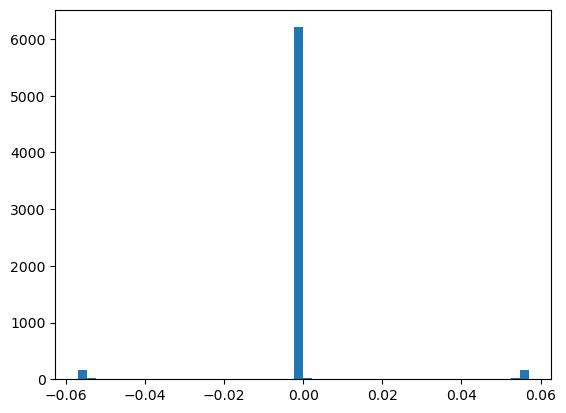

In [42]:
_ = plt.hist(diff, bins=50)

In [43]:
mask1 = np.array(diff)>0.02
mask1 = np.insert(mask1, 0, False)
mask2 = np.array(diff)<-0.02
mask2 = np.insert(mask2, 0, False)

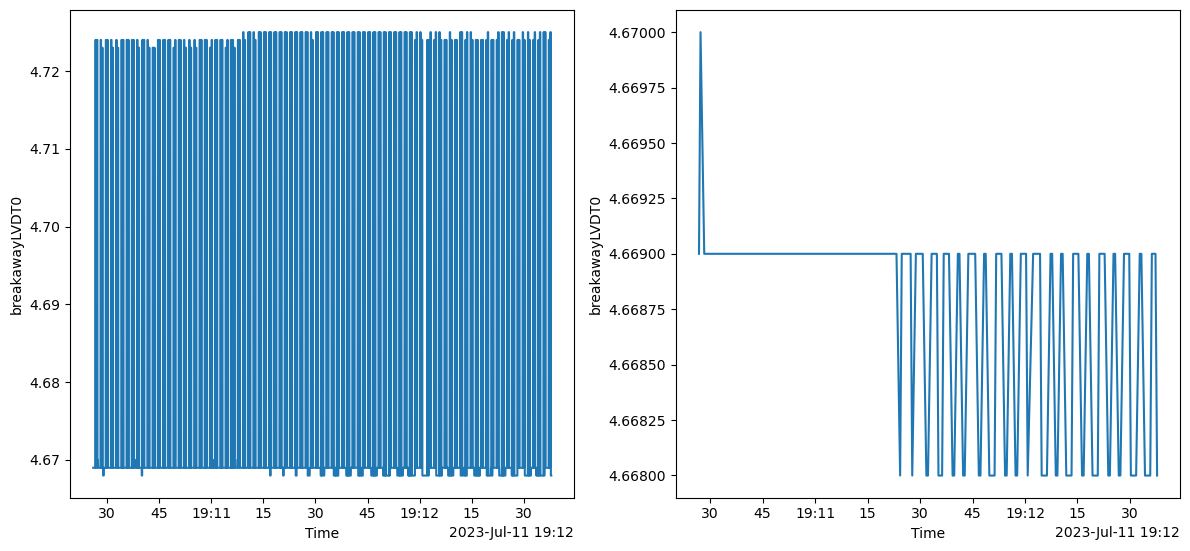

In [51]:
locator = mdates.AutoDateLocator(minticks=3, maxticks=3)
formatter = mdates.ConciseDateFormatter(locator)

fig, axs = plt.subplots(num=title, nrows=1, ncols=2, figsize=(12, 6))

axs[0].plot(df_hpmd.index, df_hpmd.breakawayLVDT4)
#axs[1].plot(df_hpmd.index[mask1], df_hpmd.breakawayLVDT4[mask1])
axs[1].plot(df_hpmd.index[mask2], df_hpmd.breakawayLVDT4[mask2])

axs[0].set_xlabel("Time")
axs[0].set_ylabel("breakawayLVDT0")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("breakawayLVDT0")

axs[0].xaxis.set_major_formatter(formatter)
axs[1].xaxis.set_major_formatter(formatter)
    
fig.tight_layout()
plt.subplots_adjust(top=0.91)

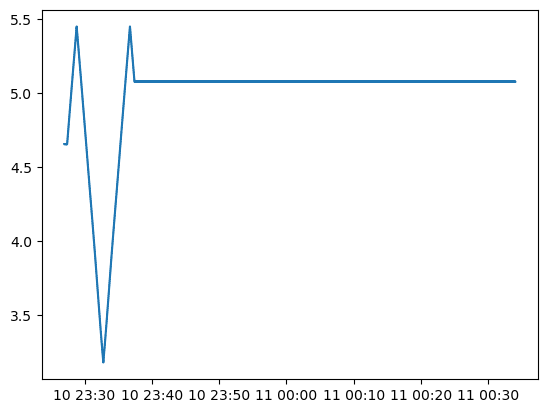

In [49]:
_ = plt.plot(df_hpmd.index, df_hpmd.displacementLVDT0)

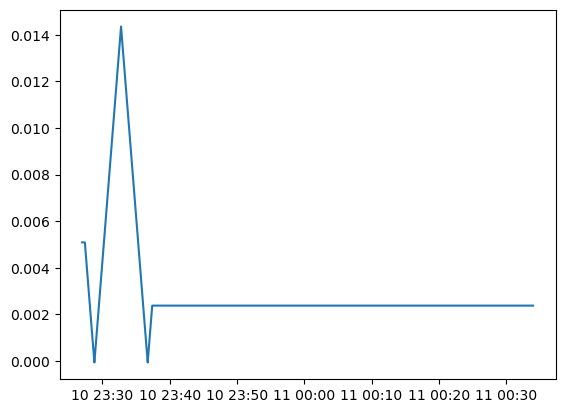

In [46]:
_ = plt.plot(df_hpad.index, df_hpad.displacement0)

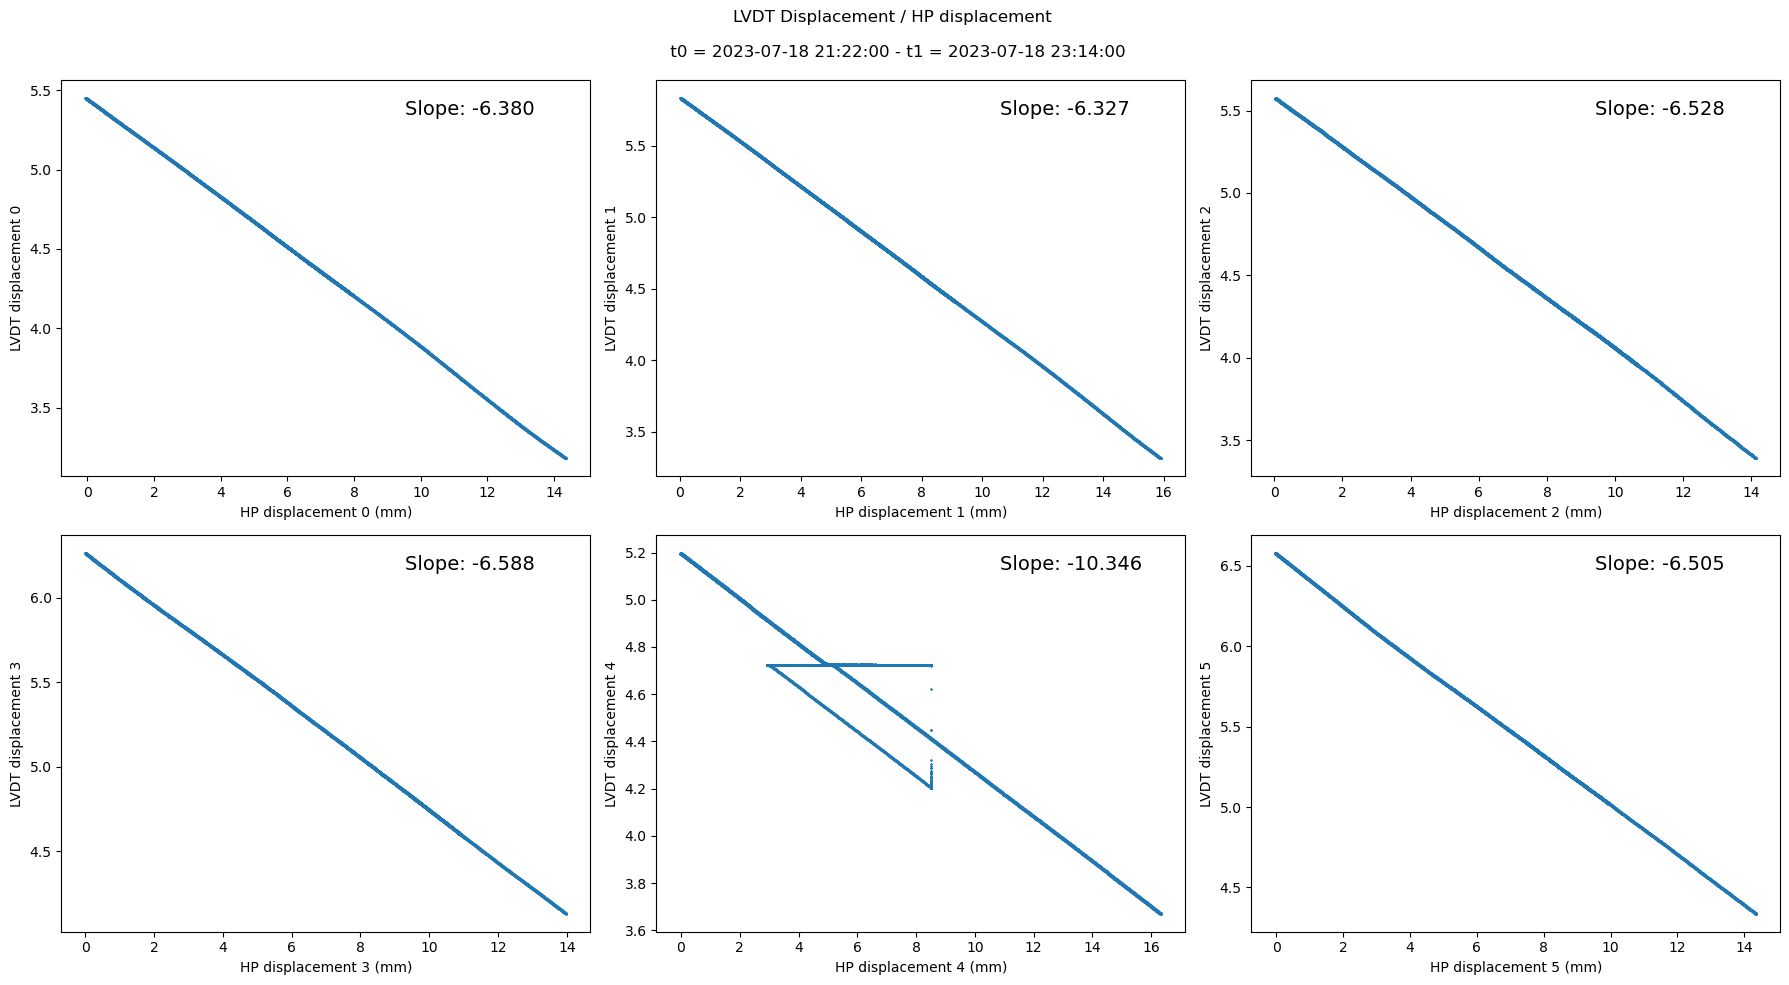

In [100]:
# Plot Hard Point LVDTDisplacement Vs HP displacement

title = f"LVDT Displacement / HP displacement \n\n t0 = {t_start.datetime} - t1 = {t_end.datetime}"
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(18, 10))

for i in range(6):
    if i < 3:
        j = 0
        k = i
    else:
        j = 1
        k = i-3
    result = linregress(df_hpmd[f"displacementLVDT{str(i)}"], df_hpad[f"displacement{str(i)}"]*1000)
    _ = axs[j][k].scatter(df_hpad[f"displacement{str(i)}"]*1000, df_hpmd[f"displacementLVDT{str(i)}"], s=0.1)
    axs[j][k].set_xlabel(f"HP displacement {str(i)} (mm)")
    axs[j][k].set_ylabel(f"LVDT displacement {str(i)}")
    axs[j][k].text(0.65, 0.95, "Slope: %.3f"%(result.slope), transform=axs[j][k].transAxes, fontsize=14,
        verticalalignment='top')

    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.91)

In [100]:
diff_ele = abs(results.start_ele - results.end_ele)
mask = diff_ele>30
np.sum(mask)

17

In [101]:
results.start_ele[mask]

12    84.999999
13     5.130000
17    44.635867
22    84.999999
23     5.000000
27    89.950000
31    -0.050000
37    89.950001
41    -0.050000
44    88.067892
48    44.999999
57    85.000000
61    45.000000
67    84.999999
71    45.000001
78    85.000001
82    45.000001
Name: start_ele, dtype: float64

In [102]:
results.end_ele[mask]

12     5.001417
13    44.998138
17    84.997905
22     5.000903
23    84.998745
27    -0.048976
31    89.948007
37    -0.046939
41    89.946723
44    45.006310
48    84.993590
57    45.005567
61    84.991277
67    45.011188
71    84.992248
78    45.005842
82    84.988886
Name: end_ele, dtype: float64

In [24]:
def select_good(results):
    # Create a mask to flag outliers
    good = np.array(len(results))
    good.fill(True)
    axes = "xyz"
    for i in axes:
        for j in ["_before", "_after"]:
            m_pos = abs(results[f"{i}{j}"]-np.median(results[f"{i}{j}"])) < 0.1
            m_rot = abs(results[f"R_{i}{j}"]-np.median(results[f"R_{i}{j}"])) < 0.01
            good = good & m_pos & m_rot
    print(f"{len(results)-np.sum(good)} entries over {len(results)} flagged as outliers") 
    return good

18 entries over 86 flagged as outliers


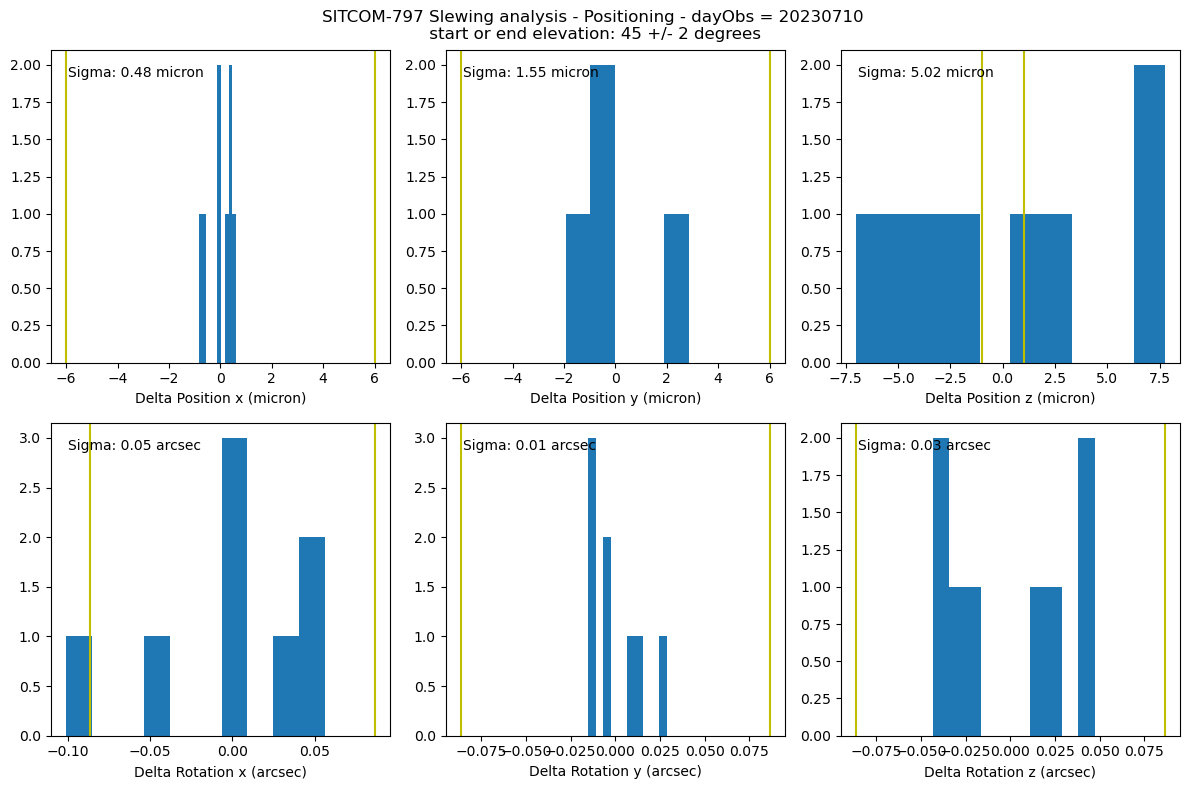

In [25]:
%matplotlib inline
# Select one elevation (because we are going to compare the mirror position at a given elevation)
elev_target = 45
elev_tol = 2

axes = "xyz"

# Flag bad values
good = select_good(results)

title = f"SITCOM-797 Slewing analysis - Positioning - dayObs = {dayObs} \n start or end elevation: {elev_target} +/- {elev_tol} degrees "
fig, axs = plt.subplots(num=title, nrows=2, ncols=3, figsize=(12, 8))

# Check whether the TMA actually move significantly in elevation
diff_ele = abs(results.start_ele - results.end_ele)
mask_move = (diff_ele > 30) & good

# Accept a small variation around the selected elevation
mask_start = abs(results.start_ele - elev_target) < elev_tol
mask_stop = abs(results.end_ele - elev_target) < elev_tol

for i in range(3):
    pos_1 = (results[f"{axes[i]}_after"][mask_move & mask_stop])
    pos_2 = (results[f"{axes[i]}_before"][mask_move & mask_start])
    pos = list(pos_1) + list(pos_2)
    avg = np.mean(pos)
    std = np.std(avg-pos)*u.mm.to(u.micron)
    axs[0][i].hist((avg-pos)*u.mm.to(u.micron))
    axs[0][i].set_xlabel(f"Delta Position {axes[i]} (micron)")
    axs[0][i].text(0.05, 0.95, "Sigma: %.2f micron"%(std), transform=axs[0][i].transAxes, fontsize=10,
        verticalalignment='top')

    
    rot_1 = (results[f"R_{axes[i]}_after"][mask_move & mask_stop])
    rot_2 = (results[f"R_{axes[i]}_before"][mask_move & mask_start])
    rot = list(rot_1) + list(rot_2)
    avg = np.mean(rot)
    std = np.std(avg-rot)*u.degree.to(u.arcsec)
    axs[1][i].hist((avg-rot)*u.degree.to(u.arcsec))
    axs[1][i].set_xlabel(f"Delta Rotation {axes[i]} (arcsec)")
    axs[1][i].text(0.05, 0.95, "Sigma: %.2f arcsec"%(std), transform=axs[1][i].transAxes, fontsize=10,
        verticalalignment='top')
    
    if axes[i] in ["x", "y"]:
        axs[0][i].axvline(6, color='y')
        axs[0][i].axvline(-6, color='y')
        axs[1][i].axvline(0.0864, color='y')
        axs[1][i].axvline(-0.0864, color='y')
    else:
        axs[0][i].axvline(1, color='y')
        axs[0][i].axvline(-1, color='y')
        axs[1][i].axvline(0.0864, color='y')
        axs[1][i].axvline(-0.0864, color='y')
    
fig.suptitle(title + "\n")
fig.tight_layout()
plt.subplots_adjust(top=0.93)

In [26]:
good

0     False
1     False
2     False
3     False
4     False
      ...  
81     True
82     True
83     True
84     True
85     True
Length: 86, dtype: bool